In [1]:
# importing all useful functions 
import math
import matplotlib.pyplot as plt
import numpy as np
from time import sleep
import gymnasium as gym
from gymnasium import Env, spaces, register, make
import random
import copy

In [2]:
class BernoulliBandit(Env):
    
    
    #----- 1 -----
    #constructor for initialization and some helper functions
    
    
    def __init__(self, render_mode=None, alpha = 1.0 , beta = 1.0):
        
        #P is basically State: Action: [ Transition Probability , Next state , Reward , isTerminated?]
        self.P = {
            0: {
                0: [(1.0, 0, 0.0, True)],
                1: [(1.0, 0, 0.0, True)]
            },
            1: {
                0: [(alpha, 0, 1.0, True), (1-alpha, 2, 0.0, True)],
                1: [(beta, 2, 1.0, True), (1-beta, 0, 0.0, True)]
            },
            2: {
                0: [(1.0, 2, 0.0, True)],
                1: [(1.0, 2, 0.0, True)]
            }
        }
        
        self.size = 3 # The size of the 1D grid
#         self.window_size = 512  # The size of the PyGame window
        
        # We have 3 observations, corresponding to each position in the 1-D grid
        self.observation_space = spaces.Discrete(self.size)

        # We have 2 actions, corresponding to "left" & "right"
        self.action_space = spaces.Discrete(2)
        self.action_space_size = 2 
        
    
    #return the locations of agent and target
    def _get_obs(self):
        return {   
            "agent" : self._agent_location, 
            "target": self._target_location  
        }
    
    #returns the distance between agent and target 
    def _get_info(self):
        return {  
            "distance": abs(self._agent_location - self._target_location)   
        }
    
    
    
    
    #----- 2 ------
    # The reset function to initiate 
    
    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        
        self._agent_location = 1             #location of agent in the begining
        self._target_location = self.size-1  #starting location of target in this case 2 
        self._dead_state = 0                 #dead location
        
        
        observation = self._get_obs()        #getting useful information
        info = self._get_info()

        return observation,info
    
    
    
    
    
    #------- 3 ---------
    # The step function 
    
    def step(self, action):  # takes action as a parameter

        # gets the current location and stores the values from P set 
        prev_location = self._agent_location                                #gets location
        transitions = self.P[prev_location][action]                         #gets the corresponding action tuple
        probabilities, next_states, rewards, terminals = zip(*transitions)  #stores the value for use 
        
        # Randomly select a transition based on the probabilities
        # gives you random state based on your probabilities 
        index = random.choices(range(len(probabilities)), weights=probabilities, k=1)[0]
        # stores the values 
        self._agent_location, reward, terminated = next_states[index], rewards[index], terminals[index]
        
        truncated = False
        observation = self._get_obs()  
        info = self._get_info()

        info["log"] = {"current_state": prev_location, 
                       "action":action,  
                        "next_state": self._agent_location}

        # Return the required 5-tuple
        return observation, reward, terminated, truncated, info
    

In [3]:
# Register the custom environment
register(id='BBandit', entry_point=BernoulliBandit)

In [4]:
# a=float(input("Enter the value of alpha -  "))
# b=float(input("Enter the value of beta -  "))

# Create and use the environment
environment = make('BBandit', alpha = 0.8 , beta = 0.8)

reward_sum = 0
observation = environment.reset(seed=0)
for _ in range(10):
    action = environment.action_space.sample()  # this is where you would insert your policy
    observation, reward, terminated, truncated, info = environment.step(action)
    reward_sum += reward
    print(info['log'])

    if terminated:
        print("Terminated", "\n")

    
    if terminated or truncated:
        observation = environment.reset(seed=0)
        
        
print(" Average Reward over 10 episode = " , int(reward_sum * 0.1))        

{'current_state': 1, 'action': 0, 'next_state': 2}
Terminated 

{'current_state': 1, 'action': 0, 'next_state': 2}
Terminated 

{'current_state': 1, 'action': 0, 'next_state': 0}
Terminated 

{'current_state': 1, 'action': 1, 'next_state': 2}
Terminated 

{'current_state': 1, 'action': 0, 'next_state': 0}
Terminated 

{'current_state': 1, 'action': 0, 'next_state': 0}
Terminated 

{'current_state': 1, 'action': 1, 'next_state': 2}
Terminated 

{'current_state': 1, 'action': 1, 'next_state': 0}
Terminated 

{'current_state': 1, 'action': 0, 'next_state': 0}
Terminated 

{'current_state': 1, 'action': 1, 'next_state': 2}
Terminated 

 Average Reward over 10 episode =  0


/Users/kislayadityaoj/opt/anaconda3/lib/python3.9/site-packages/gymnasium/utils/passive_env_checker.py:127: UserWarning: WARN: The obs returned by the `reset()` method should be an int or np.int64, actual type: <class 'dict'>
  logger.warn(f"{pre} should be an int or np.int64, actual type: {type(obs)}")
/Users/kislayadityaoj/opt/anaconda3/lib/python3.9/site-packages/gymnasium/utils/passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
/Users/kislayadityaoj/opt/anaconda3/lib/python3.9/site-packages/gymnasium/utils/passive_env_checker.py:127: UserWarning: WARN: The obs returned by the `step()` method should be an int or np.int64, actual type: <class 'dict'>
  logger.warn(f"{pre} should be an int or np.int64, actual type: {type(obs)}")
/Users/kislayadityaoj/opt/anaconda3/lib/python3.9/site-packages/gymnasium/utils/passive_env_checker.py:159: UserWarning: WARN

In [5]:
# Greedy Stratergy - Pure Exploitation 

def PureExploitation(Env , maxEpisodes):
    
    Q = np.zeros(Env.action_space_size)
    N = np.zeros(Env.action_space_size)
    e=1
    Q_est = np.zeros((maxEpisodes,Env.action_space_size))
    R_est = np.zeros(maxEpisodes)
    obs = Env.reset(seed=0)
    sum =0
    opti=0
    
    while e < maxEpisodes :
        a = Q.argmax()
        R = Env.step(a)[1]
        sum = sum + R
        N[a]= N[a]+1
        Q[a]= Q[a] + ((R - Q[a])/N[a])
        Q_est[e]=Q
        if max(Q) == Q[a]:
            opti+=1
        #change R_est according to need of question 
        R_est[e]= (opti/e)*100
        e=e+1
        obs = Env.reset(seed=0)
    
#     print(" left-action | right-action  | reward")
#     for i in range(maxEpisodes):
#         print(f"{Q_est[i][0]:12.6f} | {Q_est[i][1]:13.6f} | {R_est[i]:6.2f}")
        
    return R_est     

    
ev = make('BBandit', alpha = 0.5 , beta = 0.5)
PureExploitation(ev , 10)    

/Users/kislayadityaoj/opt/anaconda3/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.action_space_size to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.action_space_size` for environment variables or `env.get_wrapper_attr('action_space_size')` that will search the reminding wrappers.
  logger.warn(


array([  0., 100., 100., 100., 100., 100., 100., 100., 100., 100.])

In [6]:
# Exploration Stratergy - Pure Exploration 

def PureExploration(Env , maxEpisodes):
    
    Q = np.zeros(Env.action_space_size)
    N = np.zeros(Env.action_space_size)
    e=1
    Q_est = np.zeros((maxEpisodes,Env.action_space_size))
    R_est = np.zeros(maxEpisodes)
    observation, info = Env.reset(seed=0)
    sum=0
    opti=0
    
    while e < maxEpisodes :
        a = np.random.randint(0,len(Q))
        R = Env.step(a)[1]
        sum += R
        N[a]= N[a]+1
        Q[a]= Q[a] + ((R - Q[a])/N[a])
        Q_est[e]=Q
        if max(Q)==Q[a]:
            opti+=1
        R_est[e]=(opti/e)*100
        e=e+1
        observation, info = Env.reset(seed=0)
    
#     print(" left-action | right-action  | reward")
#     for i in range(maxEpisodes):
#         print(f"{Q_est[i][0]:12.6f} | {Q_est[i][1]:13.6f} | {R_est[i]:6.2f}")

    return R_est
    
ev = make('BBandit', alpha = 0.5 , beta = 0.5)
PureExploration(ev , 10)

array([  0.        , 100.        ,  50.        ,  33.33333333,
        25.        ,  20.        ,  16.66666667,  14.28571429,
        25.        ,  22.22222222])

In [7]:
# epsilon - Greedy stratergy

def EpsilonGreedy(Env , maxEpisodes , epsilon = 0.5):
    
    Q = np.zeros(Env.action_space_size)
    N = np.zeros(Env.action_space_size)
    e=1
    Q_est = np.zeros((maxEpisodes,Env.action_space_size))
    R_est = np.zeros(maxEpisodes)
    observation, info = Env.reset(seed=0)
    sum=0
    opti=0
    while e < maxEpisodes :
        temp = np.random.randint(0,1)
        if temp > epsilon :
            a=Q.argmax()
        else :
            a=np.random.randint(0,len(Q))
        R = Env.step(a)[1]
        sum += R
        N[a]= N[a]+1
        Q[a]= Q[a] + ((R - Q[a])/N[a])
        Q_est[e]=Q
        if max(Q)==Q[a]:
            opti+=1
        R_est[e]=(opti/e)*100
        e=e+1
        observation, info = Env.reset(seed=0)
    
#     print(" left-action | right-action  | reward")
#     for i in range(maxEpisodes):
#         print(f"{Q_est[i][0]:12.6f} | {Q_est[i][1]:13.6f} | {R_est[i]:6.2f}")
    
    return R_est 


ev = make('BBandit', alpha = 0.5 , beta = 0.5)
#ep = float(input("Enter the value of epsilon between 0 and 1 = "))
EpsilonGreedy(ev , 10 , 0.5)

array([  0.        , 100.        , 100.        , 100.        ,
       100.        , 100.        ,  83.33333333,  85.71428571,
        75.        ,  66.66666667])

In [8]:
# Decaying epsilon - Greedy stratergy

def decayingEpsilonGreedy(Env , maxEpisodes , choice = 0):
    
    Q = np.zeros(Env.action_space_size)
    N = np.zeros(Env.action_space_size)
    e=1
    sum=0
    opti=0
    Q_est = np.zeros((maxEpisodes,Env.action_space_size))
    R_est = np.zeros(maxEpisodes)
    observation, info = Env.reset(seed=0)
    epsilon = 1 
    while e < maxEpisodes :
        if choice == 0:
            #linear decay
            epsilon = epsilon - (e/maxEpisodes)
        else :
            #exponential decay
            epsilon = epsilon * math.exp(-(e/maxEpisodes))
            
            
        temp = np.random.randint(0,1)
        if temp > epsilon :
            a=Q.argmax()
        else :
            a=np.random.randint(0,len(Q))
        R = Env.step(a)[1]
        sum += R
        N[a]= N[a]+1
        Q[a]= Q[a] + ((R - Q[a])/N[a])
        Q_est[e]=Q
        if max(Q)==Q[a]:
            opti+=1
        R_est[e]=(opti/e)*100
        e=e+1
        observation, info = Env.reset(seed=0)
    
#     print(" left-action | right-action  | reward")
#     for i in range(maxEpisodes):
#         print(f"{Q_est[i][0]:12.6f} | {Q_est[i][1]:13.6f} | {R_est[i]:6.2f}")
    
    return R_est


ev = make('BBandit', alpha = 0.5 , beta = 0.5)
#ep = float(input(" Choose the type of decay , 0 -> linear , 1 -> exponential = "))
decayingEpsilonGreedy(ev , 10 , 0)

array([  0.        , 100.        ,  50.        ,  66.66666667,
        75.        ,  80.        ,  83.33333333,  85.71428571,
        87.5       ,  88.88888889])

In [9]:
# SoftMax stratergy
def softmax(x):
    #Compute softmax values for each sets of scores in x.
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()


def Softmax(Env , maxEpisodes , t=10):
    
    Q = np.zeros(Env.action_space_size)
    N = np.zeros(Env.action_space_size)
    e=1
    sum=0
    opti=0
    Q_est = np.zeros((maxEpisodes,Env.action_space_size))
    R_est = np.zeros(maxEpisodes)
    observation, info = Env.reset(seed=0)
    t_not = copy.copy(t)
    
    while e < maxEpisodes :
        probs = softmax(Q/t)
        a= random.choices(range(Env.action_space_size), weights=probs, k=1)[0]
        R = Env.step(a)[1]
        sum+=R
        N[a]= N[a]+1
        Q[a]= Q[a] + ((R - Q[a])/N[a])
        t = t - ((e/maxEpisodes)*t_not)   #linearly decaying temperature
        Q_est[e]=Q
        if max(Q)==Q[a]:
            opti+=1
        R_est[e]=(opti/e)*100
        e=e+1
        observation, info = Env.reset(seed=0)
    
#     print(" left-action | right-action  | reward")
#     for i in range(maxEpisodes):
#         print(f"{Q_est[i][0]:12.6f} | {Q_est[i][1]:13.6f} | {R_est[i]:6.2f}")
    
    return R_est


ev = make('BBandit', alpha = 0.5 , beta = 0.5)
#ep = float(input(" Choose the value of Temperature = "))
Softmax(ev , 10 , 10)

/var/folders/sc/63b24d_x7_q7jtckgsd8mx000000gn/T/ipykernel_80093/1431403319.py:21: RuntimeWarning: divide by zero encountered in true_divide
  probs = softmax(Q/t)
/var/folders/sc/63b24d_x7_q7jtckgsd8mx000000gn/T/ipykernel_80093/1431403319.py:4: RuntimeWarning: invalid value encountered in subtract
  e_x = np.exp(x - np.max(x))


array([  0.        , 100.        ,  50.        ,  33.33333333,
        50.        ,  40.        ,  50.        ,  57.14285714,
        50.        ,  55.55555556])

In [10]:
# UCB stratergy

def UCB(Env , maxEpisodes , c=10):
    
    Q = np.zeros(Env.action_space_size)
    N = np.zeros(Env.action_space_size)
    e=1
    sum=0
    Q_est = np.zeros((maxEpisodes,Env.action_space_size))
    R_est = np.zeros(maxEpisodes)
    observation, info = Env.reset(seed=0)
    opti=0
    
    while e < maxEpisodes :
        if e < len(Q) :
            a=e
        else :
            U = c * math.sqrt(math.log(e,10)/N[a])
            a= (Q+U).argmax()
        R = Env.step(a)[1]
        sum+=R
        N[a]= N[a]+1
        Q[a]= Q[a] + ((R - Q[a])/N[a])
        if max(Q) == Q[a]:
            opti+=1
        Q_est[e]=Q
        R_est[e]= (((opti)/e)*100)
        e=e+1
        observation, info = Env.reset(seed=0)
    
#     print(" left-action | right-action  | reward")
#     for i in range(maxEpisodes):
#         print(f"{Q_est[i][0]:12.6f} | {Q_est[i][1]:13.6f} | {R_est[i]:6.2f}")
    
    return R_est


ev = make('BBandit', alpha = 0.5 , beta = 0.5)
#ep = float(input(" Choose the value of c = "))
UCB(ev , 10 , 10)

array([  0., 100., 100., 100., 100., 100., 100., 100., 100., 100.])

/Users/kislayadityaoj/opt/anaconda3/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.action_space_size to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.action_space_size` for environment variables or `env.get_wrapper_attr('action_space_size')` that will search the reminding wrappers.
  logger.warn(
/Users/kislayadityaoj/opt/anaconda3/lib/python3.9/site-packages/gymnasium/utils/passive_env_checker.py:127: UserWarning: WARN: The obs returned by the `reset()` method should be an int or np.int64, actual type: <class 'dict'>
  logger.warn(f"{pre} should be an int or np.int64, actual type: {type(obs)}")
/Users/kislayadityaoj/opt/anaconda3/lib/python3.9/site-packages/gymnasium/utils/passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
/Users/kislayadityaoj/opt/

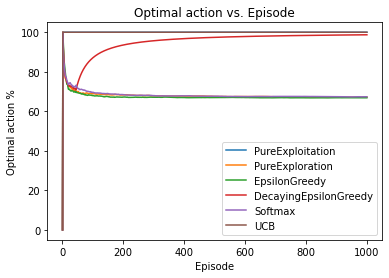

In [14]:
# Question 1 . 4 
y_axis1 = np.zeros(1000)
y_axis2 = np.zeros(1000)
y_axis3 = np.zeros(1000)
y_axis4 = np.zeros(1000)
y_axis5 = np.zeros(1000)
y_axis6 = np.zeros(1000)
for j in range(50):
    a = np.random.normal(loc=0, scale=1)
    b = np.random.normal(loc=0, scale=1)

    ev = make('BBandit', alpha = a , beta = b)

    y_axis1 = y_axis1 + PureExploitation(ev,1000)
    y_axis2 = y_axis2 + PureExploration(ev,1000)
    y_axis3 = y_axis3 + EpsilonGreedy(ev,1000)
    y_axis4 = y_axis4 + decayingEpsilonGreedy(ev,1000)
    y_axis5 = y_axis5 + Softmax(ev,1000)
    y_axis6 = y_axis6 + UCB(ev,1000)
        
# Average the accumulated data
y_axis1 /= 50
y_axis2 /= 50
y_axis3 /= 50
y_axis4 /= 50
y_axis5 /= 50
y_axis6 /= 50
   
x_axis = np.linspace(1,1000,1000)    

# Plot the data
plt.plot(x_axis, y_axis1, label='PureExploitation')
plt.plot(x_axis, y_axis2, label='PureExploration')
plt.plot(x_axis, y_axis3, label='EpsilonGreedy')
plt.plot(x_axis, y_axis4, label='DecayingEpsilonGreedy')
plt.plot(x_axis, y_axis5, label='Softmax')
plt.plot(x_axis, y_axis6, label='UCB')

# Add labels and legend
plt.title('Optimal action vs. Episode')
plt.xlabel('Episode')
plt.ylabel('Optimal action %')
plt.legend()

plt.xscale('log')

#plt.savefig("opti3.png", format="png", dpi=1200)

# Show the plot
plt.show()




/Users/kislayadityaoj/opt/anaconda3/bin/python
